![NJ Realtors](https://www.insidernj.com/wp-content/uploads/2018/01/NJ-Realtors-Logo.jpg)


In [ ]:
# /content is the default directory of Google Colab. Googel Drive needs to be mounted in order to access the My Drive directory
from google.colab import drive
import os
from PIL import Image
current_wd = os.getcwd()
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

#Problem Statement:

##### The current system (or lack thereof) for real estate agents to analyze their local and distance markets is inefficient and time consuming. To properly represent clients and meet their needs, an agent needs to spend many hours throughout the week tracking recent sales, inventory, home prices and conducting comparable sales analysis. With this information, an agent can thoroughly understand market dynamics, when, where and how a buyer should purchase a property or to sell a home. However, markets change on a daily, weekly and monthly basis. This can be overwhelming for new and even established agents as NJ has 4-5 different private MLS services which organize and display their data with different methods. This inefficiency can lead to increased frustration and lack of understanding with ones job, increased inability to keep up with fast paced markets, decreased client satisfaction and loss of revenue (salary).

##### The goal of this project is intended to achieve multiple objectives:


1.   Create a system which automatically collects, cleans and stores real estate data on a monthly basis for recent sales and municipality level data respectively
2.   Observe market activity on a municiple level
3.   Understand the relationship between a municipality's population and it's dependent varaibles
4.   Cluster municipalities based on similarities found through unsupervised machine learning
5.   Create a dashboard to display market statistics as well as provide the ability to conduct data/market analysis


# Designing the System

##### The data pipeline has been created and maintained outside of this Jupyter Notebook through the use of the Selenium and Requests modules. The pipeline operates as follows:
1. Selenium is used to log into the real estate portal to scrape the initial webpage containing the names of all municipalites.
2. Requests will be used to send inidividual requests to receive  the host server for each municipality for that month and year
3. After all target pdfs are streamed, begin scrapping the data using PyPDF2 and Regex
4. Store data in a temporary Python dictionary
5. Convert Python dictionary into Pandas DataFrame
6. Initiate data cleaning and transformations
7. Store DataFrame in Excel worksheet or PostgreSQL

##### As this is just a preliminary pipeline, this will later be refactored to clean up the code and implement either a stream or batch processing module like Apache Kafka or Spark

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from statistics import stdev
import warnings
import asyncio
import aiohttp
import requests
import geopandas


In [ ]:
def save_picture(fig, picture_name):
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks/GitHub_Pictures')
  fig.savefig(f'{picture_name}.jpeg', bbox_inches='tight')
  os.chdir(previous_wd)

In [ ]:
def get_us_pw(website):
  # Saves the current directory in a variable in order to switch back to it once the program ends
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive')

  db = pd.read_excel('get_us_pw.xlsx', index_col=0)
  username = db.loc[website, 'Username']
  pw = db.loc[website, 'Password']
  base_url = db.loc[website, 'Base URL']

  os.chdir(previous_wd)

  return username, base_url, pw

In [ ]:
from sqlalchemy import create_engine
*username, pw = get_us_pw('PostgreSQL')
engine = create_engine(f"postgresql+psycopg2://{username[0]}:{pw}@{username[1]}:5432/nj_realtor_data")

In [ ]:
# Load dataset
data = pd.read_sql_table('nj_realtor_final_v2', engine)
pd.set_option('display.max_columns', None)
data.head()

,Municipality,County,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),NL% of Total Inventory (State),NL% of Total Inventory (County),County Sales Attr. By City,State Sales Attr. By City,County Inventory Attr. By City,State Inventory Attr. By City,County New Listings Attr. By City,State New Listings Attr. By City,Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Bicycle,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Total Population Estimate,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,EMP,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,AVG PAYANN PER EMP,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
0,Aberdeen Twp,Monmouth County,2019,12.500000,-0.311500,14.000000,-0.176250,57.000000,0.053250,363375.000000,0.055750,0.978000,-0.015250,39.500000,-0.215250,2.525000,-0.269000,-0.022591,-0.223178,0.017749,-0.023810,0.004625,-0.107463,-0.089637,0.000600,0.007334,0.038280,0.003377,0.023302,0.001989,0.029849,0.002547,40.430068,-74.225075,973.99,81.7,11.7,0.7,0.1,4.9,37.4,3.1,101363.0,45785,39.709677,40.0,18540.0,18.7,29.2,1.900000,95.6,4.4,64.3,14.0,21.4,37.8,23.5,2.1,74.5,25.5,74.3,2495.0,1670.0,0.02612,6340.0,300133.373800,7839.48,49.70,0.651583,19352.0,1278.0,15567.0,66.04,12.18,73283.42,1140803.0,2.0,1.0,1.0,113.57
1,Aberdeen Twp,Monmouth County,2020,19.090909,0.102182,14.727273,0.000182,52.181818,0.050091,388713.636364,0.069273,0.998273,0.022000,31.090909,-0.447182,2.100000,-0.411636,0.025417,0.032822,0.164538,0.151227,0.003137,-0.039063,-0.043888,0.000952,0.010883,0.023176,0.002073,0.017825,0.001556,0.025203,0.002366,40.430068,-74.225075,680.16,78.2,11.6,0.8,0.3,7.6,37.8,8.5,108132.0,50392,36.548387,41.7,18729.0,22.6,26.8,7.760377,96.9,3.1,64.9,16.3,20.9,38.5,21.2,1.9,75.5,24.5,71.6,2382.0,1691.0,0.02536,6347.0,312721.867024,7930.63,50.34,0.651583,19288.0,1278.0,15567.0,66.26,12.18,73283.42,1140803.0,2.0,1.0,1.0,123.89
2,Aberdeen Twp,Monmouth County,2021,17.833333,-0.023250,16.083333,0.243333,34.083333,-0.258500,476864.583333,0.227917,1.022500,0.028333,22.833333,-0.431083,1.391667,-0.498833,0.020368,0.077641,0.131135,0.075500,0.002372,-0.001872,0.004797,0.001090,0.013922,0.025648,0.002206,0.017596,0.001383,0.023844,0.002092,40.430068,-74.225075,391.76,76.7,10.3,0.8,0.3,10.4,36.9,5.9,111964.0,54145,31.416667,41.3,19184.0,22.5,26.4,2.800000,96.6,3.4,63.5,16.4,21.2,37.4,21.5,2.3,74.6,25.4,71.8,2438.0,1850.0,0.02524,6346.0,317217.048535,8006.56,50.81,0.583708,19350.0,1278.0,15567.0,66.05,12.18,73283.42,1140803.0,2.0,1.0,1.0,121.85
3,Aberdeen Twp,Monmouth County,2022,16.000000,-0.088000,12.083333,-0.340083,31.250000,-0.087917,535429.166667,0.159000,1.027833,

In [ ]:
data = data[[i for i in data.columns if 'Attr.' not in i and 'NL%' not in i and i not in ['Municipality', 'County', 'Total Population Estimate', 'Means of Transportation: Bicycle', 'EMP', 'AVG PAYANN PER EMP']]]

In [ ]:
# These features are on completely different scales and will require standardization/normalization
data.describe().round(2)

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2.204000e+03,2.204000e+03,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00,2204.00
mean,2020.50,14.87,0.03,12.25,0.12,47.42,0.03,457652.24,0.13,0.91,-0.02,38.36,-0.24,3.16,-0.21,0.03,0.08,0.12,0.17,-0.00,0.01,0.01,40.33,-74.55,1799.00,80.77,6.02,2.13,9.44,31.32,5.85,103588.87,50961.38,36.67,-1.814839e+06,-2.117330e+06,33.97,9.82,89.11,10.89,66.41,10.90,22.02,35.70,22.84,6.86,73.01,26.99,64.29,2606.63,1557.88,0.03,4368.99,355701.90,8650.13,38.87,0.57,16133.61,557.50,61.27,12.67,580134.51,2.57,0.39,0.35,114.55
std,1.12,14.89,0.33,13.10,0.42,25.66,0.43,356532.41,0.24,0.22,0.10,50.09,0.27,2.35,0.35,0.10,0.23,0.22,0.53,0.03,0.09,0.09,0.56,0.40,6516.98,11.26,7.13,2.63,7.30,5.35,2.80,38325.34,21536.65,5.14,3.474443e+07,3.751974e+07,9.98,9.44,15.39,15.39,22.99,8.35,10.31,10.69,11.68,7.19,18.28,18.28,10.16,683.36,447.55,0.02,5144.23,334266.01,4033.16,44.42,0.22,25783.78,801.85,170.34,9.63,1143373.80,4.18,0.77,0.73,24.24
min,2019.00,0.00,-1.00,0.00,-0.86,0.00,-0.93,0.00,-0.81,0.00,-0.75,0.00,-1.00,0.00,-1.00,-0.58,-0.58,-0.58,-0.62,-0.50,-0.38,-0.37,38.93,-75.50,0.00,0.00,0.00,0.00,0.00,13.70,1.70,22125.00,0.00,20.28,-6.666667e+08,-6.666667e+08,0.00,0.10,11.70,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1063.00,99.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.85
25%,2019.75,4.83,-0.15,3.75,-0.12,31.56,-0.21,250400.00,0.03,0.95,-0.01,10.83,-0.42,1.64,-0.45,0.00,0.00,0.00,0.00,-0.00,-0.04,-0.04,39.87,-74.89,527.87,75.88,1.40,0.60,4.60,27.70,3.50,76797.25,37346.50,33.10,3.960000e+01,2.200000e+01,28.80,4.20,89.90,4.00,51.70,4.07,14.38,27.90,13.98,2.60,62.90,12.60,60.58,2081.50,1263.00,0.02,1207.75,181063.99,6311.27,9.18,0.41,3421.00,113.00,19.20,7.70,49770.50,0.00,0.00,0.00,99.25
50%,2020.50,10.00,-0.02,8.09,0.04,43.80,-0.04,383583.33,0.12,0.99,0.01,21.33,-0.28,2.51,-0.28,0.01,0.03,0.06,0.06,0.00,0.00,0.00,40.43,-74.52,10

# Correlation matrix for the target data set

### Correlation: Unit of measurement of how two variables change with respect to one another

##### Correlations worth noting:

1.   Median Sales Prices: Weak correlations with other features. 0.12 correlation with Months of Supply
2.   New Listings: Very strong positive correlation (0.82) with Closed Sales and Inventory of Homes for Sales (0.67)
3.  Closed Sales: Strong correlation with Inventory of Homes for Sale (0.63)
4.  Days on Markets: Semi-strong negative correlation with Percent of Listong Prices Received (-0.425) and Months of Supply (0.27)
5.  Percent of Listing Prices Received: Semi-strong negative correlation with Months of Supply (-0.296)







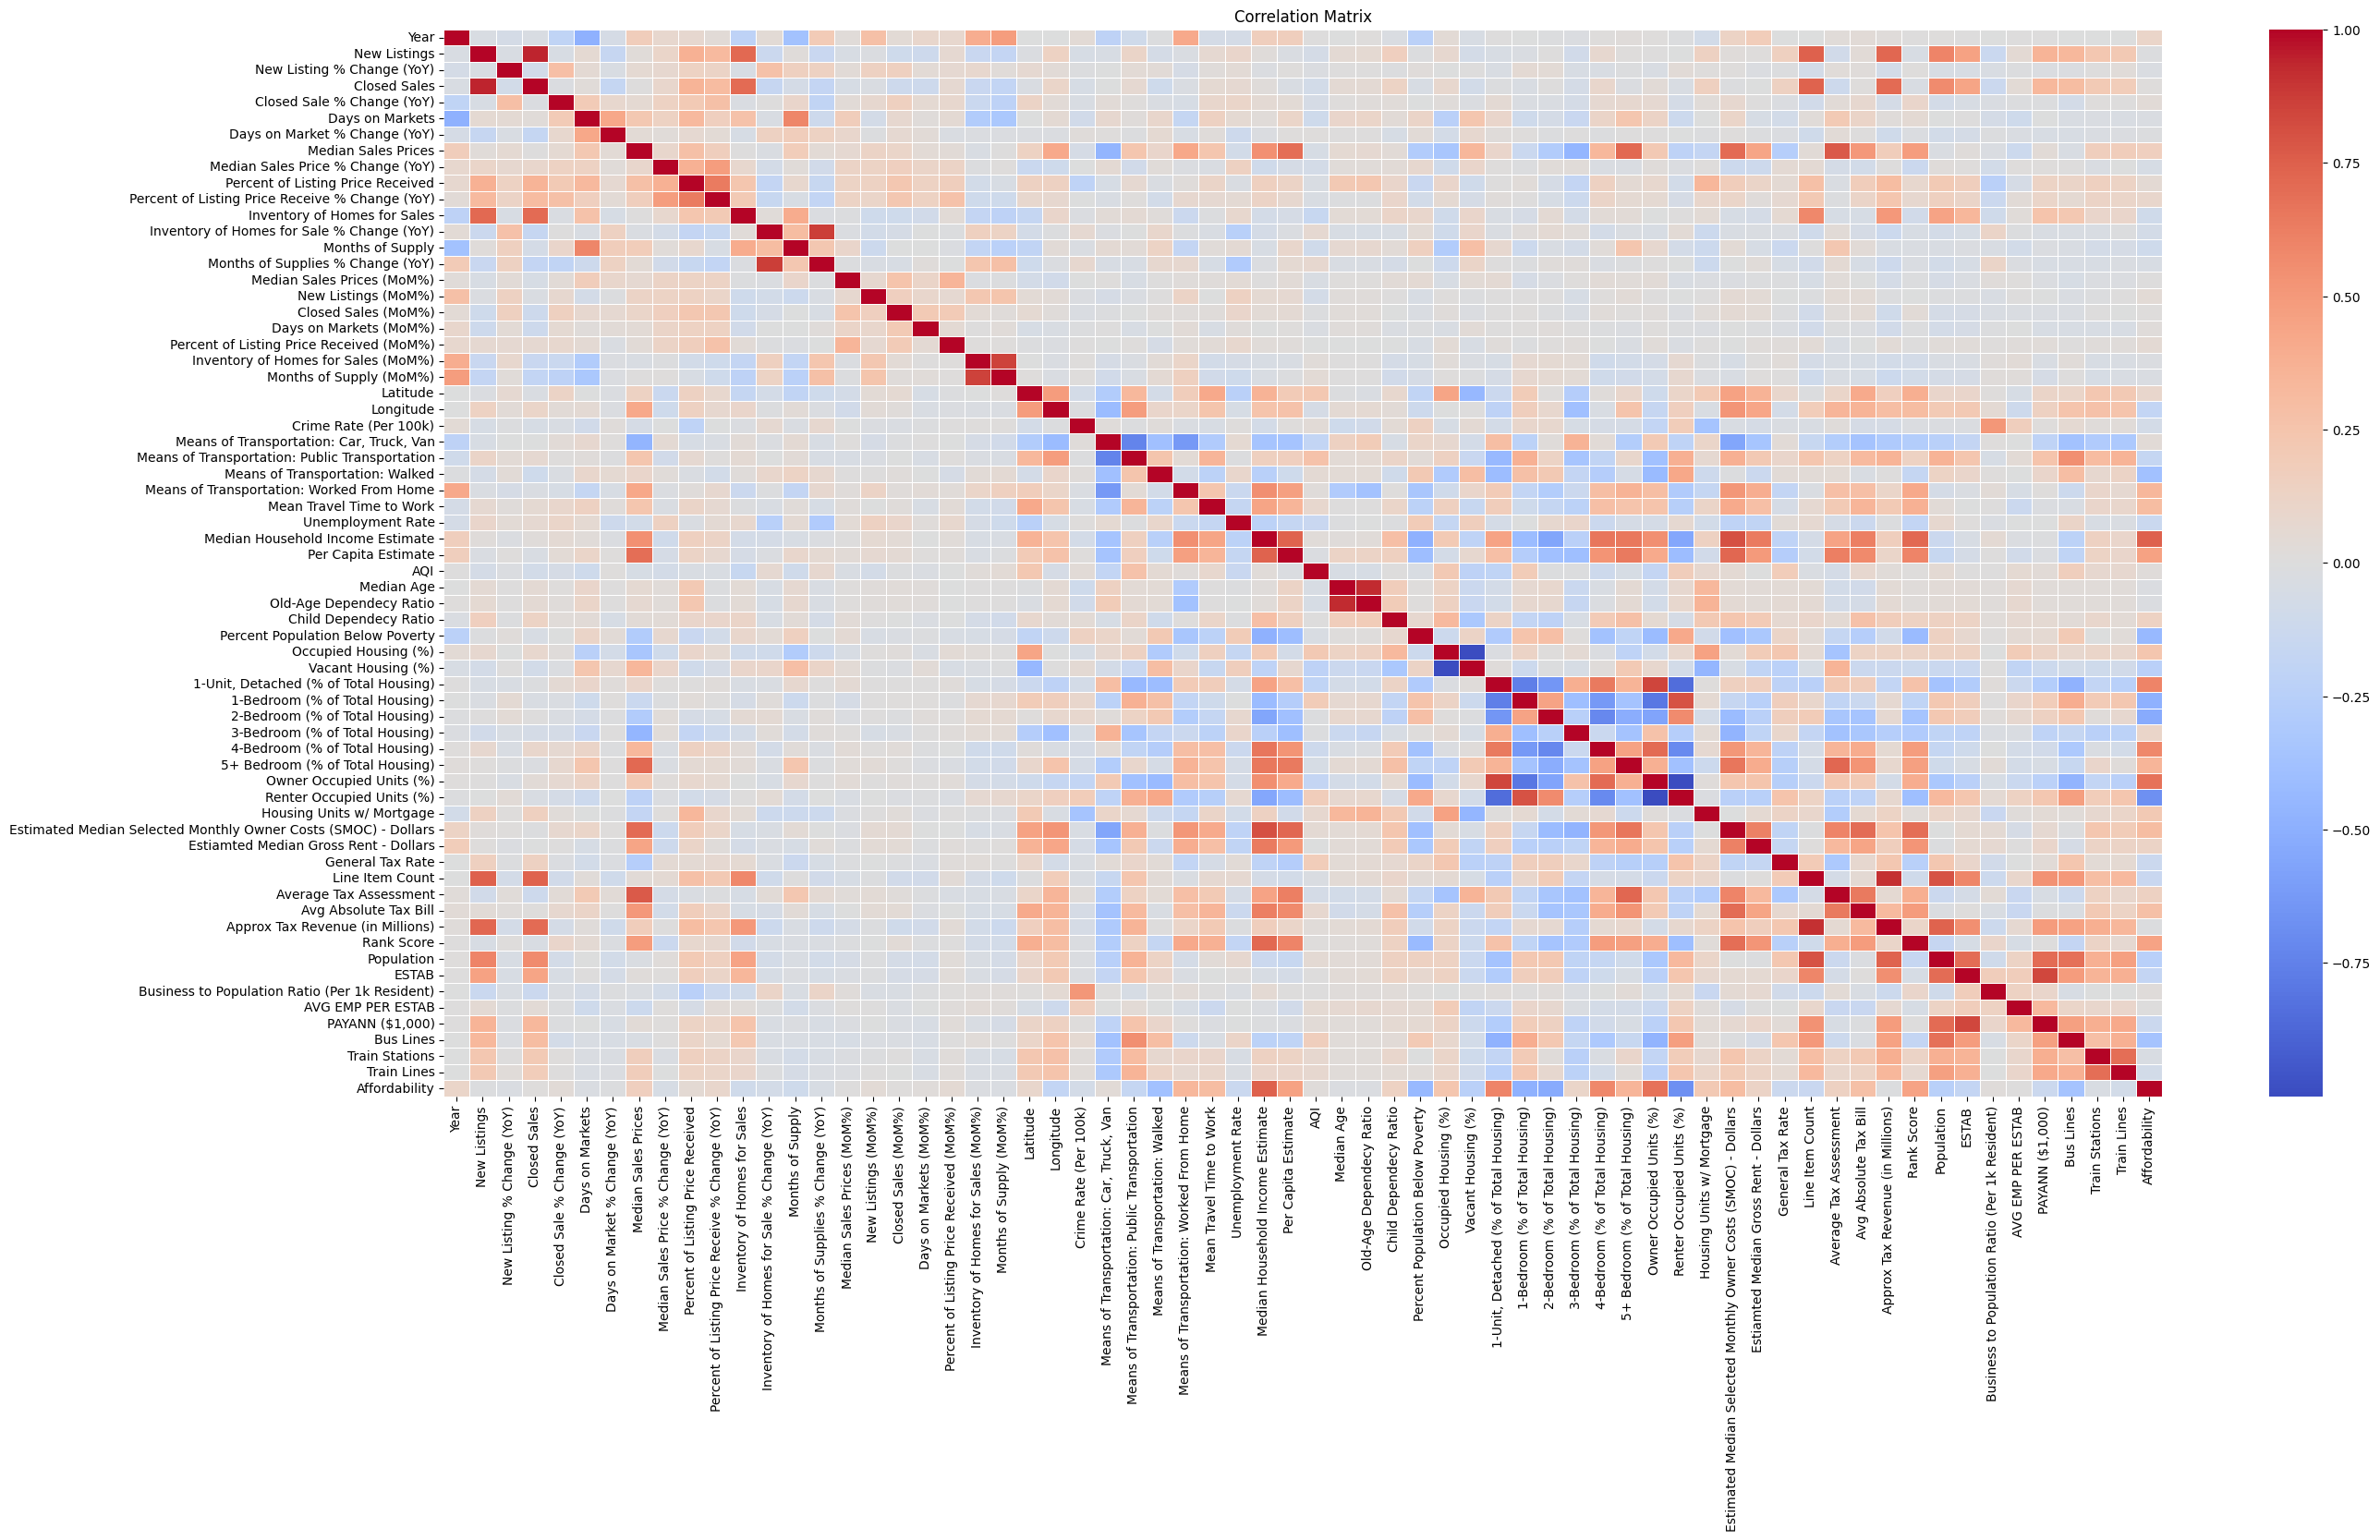

In [ ]:
fig, axs = plt.subplots(figsize=(30,15))
correlation_matrix = data[[column for column in data.columns if column not in ['Municipality', 'County'] and 'Z-Score' not in column]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidth=0.5, ax=axs)
plt.title('Correlation Matrix')
plt.show()
save_picture(fig, 'Correlation Matrix')

# Covariance

### Covariance: A measure of how two variables move together with respect to each other

##### Additional Info:


1.   Helpful to determine the type of relationship between variables
2.   Magnitude not easily interpretable
3.   Higher magnitude means more dependent relationship. An increase in one variable would lead to an increase in another variable
4.   A negative covaraince denotes an inverse relationship between the two varaibles

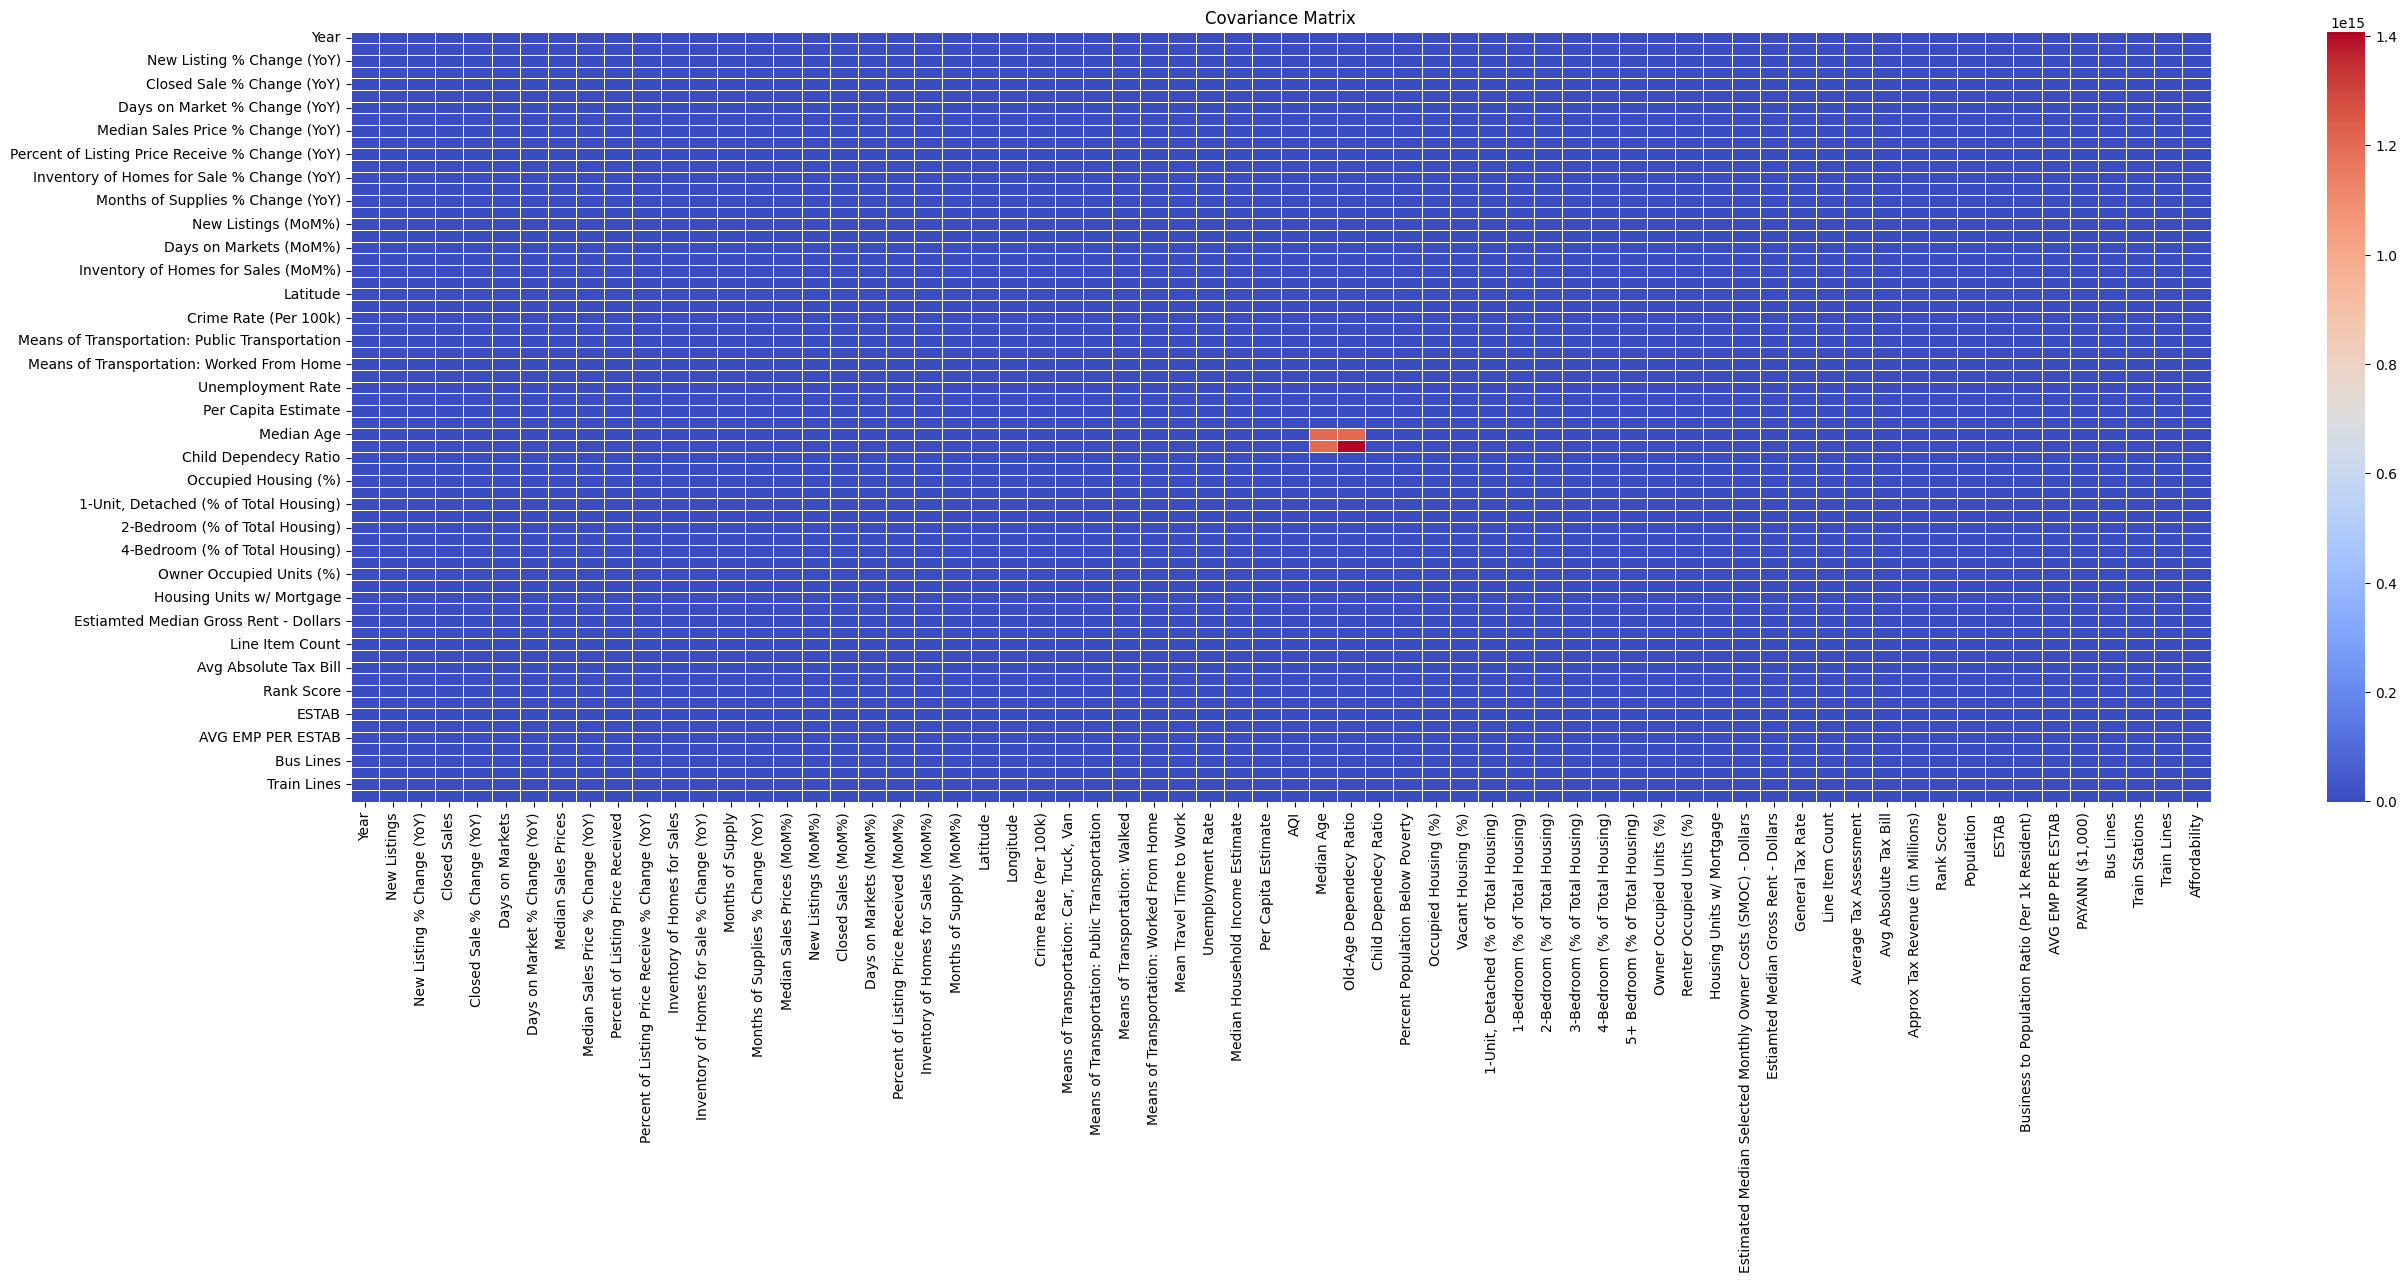

In [ ]:
plt.figure(figsize=(30,10))
covariance_matrix = data[[column for column in data.columns if column not in ['Municipality', 'County'] and 'Z-Score' not in column]].cov()
sns.heatmap(covariance_matrix, annot=False, cmap='coolwarm', linewidth=0.5)
plt.title('Covariance Matrix')
plt.show()


###VIF

Insert excerpt here about VIF analysis

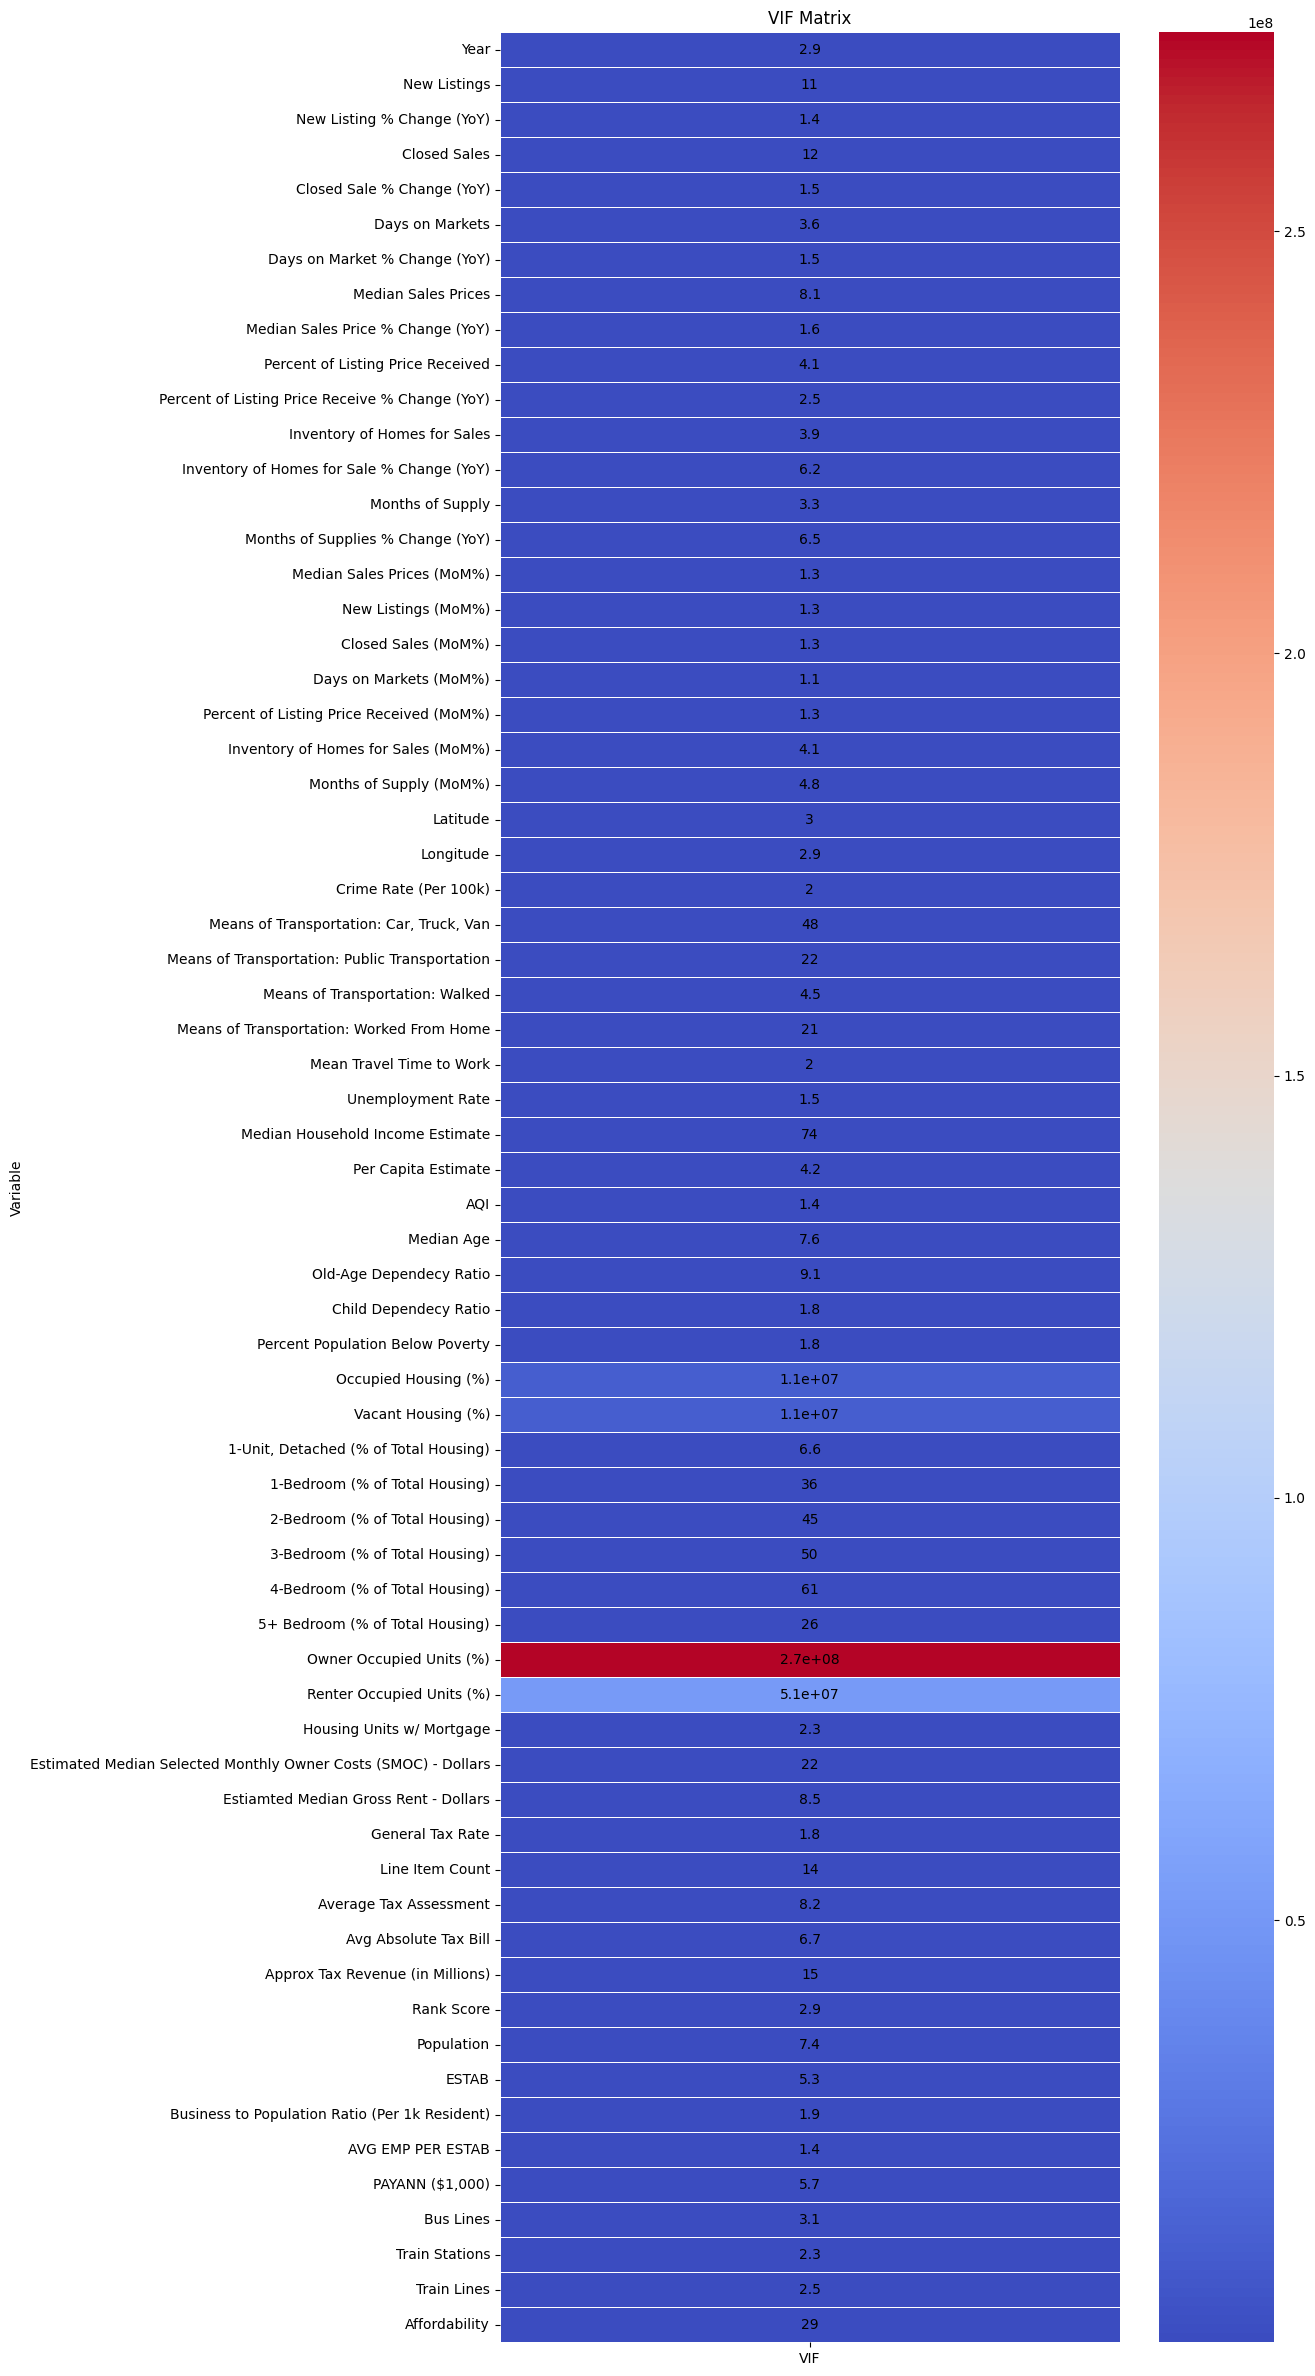

In [ ]:
# I need to take out the columns which have string dtypes
temp_df = data[[column for column in data.columns if column not in ['Municipality', 'County'] and 'Z-Score' not in column]]
# temp_df.replace([np.inf, -np.inf], 0, inplace=True)
# # temp_df = temp_df[temp_df !=0]
# temp_df = temp_df.dropna()

vif_data = pd.DataFrame()
vif_data['Variable'] = temp_df.columns
vif_data['VIF'] = [statsmodels.stats.outliers_influence.variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])] # ***this 1 may not work for my data Print the VIF table and
vif_data.set_index('Variable', inplace=True)
fig, axs = plt.subplots(figsize=(10,30))
sns.heatmap(vif_data, annot=True, cmap='coolwarm', linewidth=0.5, annot_kws={'color': 'black'}, ax=axs)
plt.title('VIF Matrix')
plt.show()
save_picture(fig, 'VIF Matrix')

In [ ]:
len(vif_data)

66

In [ ]:
from itertools import product

rows = [i for i in range(0, 6)]
cols = [i for i in range(0,5)]

combinations = list(product(rows, cols))

In [ ]:
skew_dict = {}

In [ ]:
temp_df.drop(columns=['Per Capita Estimate', 'General Tax Rate', 'Population'], inplace=True)

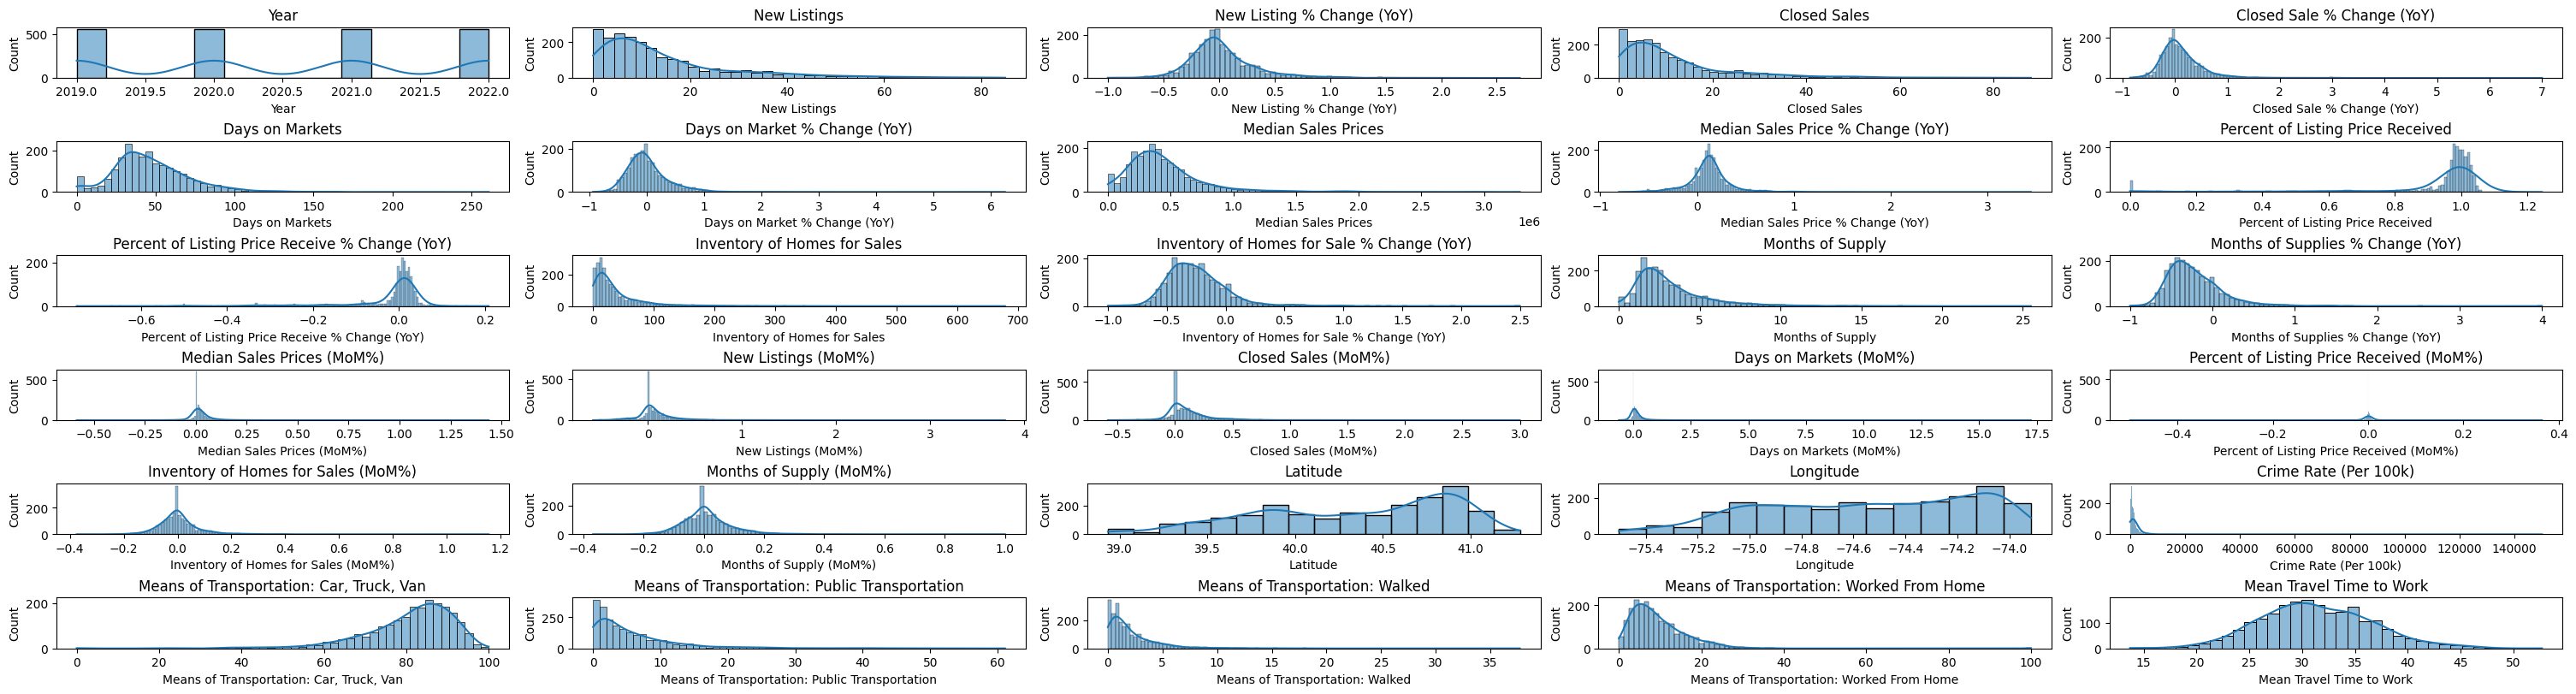

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=6, layout='constrained', figsize=(30,8))

for combo, col in zip(combinations, temp_df.columns[:31]) :

  row = combo[0]
  cols = combo[1]

  sns.histplot(data=temp_df, x=col, ax=axs[row, cols], kde=True)
  axs[row, cols].set_title(col)


plt.show()
save_picture(fig, 'Histogram Matrix 1')

In [ ]:
for col in temp_df.columns:

  skew_dict[col] = temp_df[col].skew()


In [ ]:
from pprint import pprint

pprint(skew_dict)

{'1-Bedroom (% of Total Housing)': 0.9244466300042826,
 '1-Unit, Detached (% of Total Housing)': -0.707592943624275,
 '2-Bedroom (% of Total Housing)': 0.6323226928678018,
 '3-Bedroom (% of Total Housing)': 0.46972516330607894,
 '4-Bedroom (% of Total Housing)': 0.5359691055231384,
 '5+ Bedroom (% of Total Housing)': 2.4893498712130446,
 'AQI': -0.8702388007653391,
 'AVG EMP PER ESTAB': 6.184426426360222,
 'Affordability': 0.15429853121586795,
 'Approx Tax Revenue (in Millions)': 2.2307640142988476,
 'Average Tax Assessment': 3.632049879888596,
 'Avg Absolute Tax Bill': 0.7039222043879951,
 'Bus Lines': 3.9685641806983956,
 'Business to Population Ratio (Per 1k Resident)': 10.290452019421155,
 'Child Dependecy Ratio': 1.5451011700593968,
 'Closed Sale % Change (YoY)': 3.763075641397255,
 'Closed Sales': 2.2022305359572503,
 'Closed Sales (MoM%)': 3.1356347063731578,
 'Crime Rate (Per 100k)': 18.620003434087987,
 'Days on Market % Change (YoY)': 3.804561175717411,
 'Days on Markets': 1.

In [ ]:
temp_df.describe()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,14.866221,0.034724,12.247382,0.118484,47.423411,0.032384,4.576522e+05,0.125662,0.910786,-0.023286,38.364693,-0.244118,3.158296,-0.213125,0.028077,0.081817,0.121461,0.166561,-0.001877,0.006965,0.011303,40.332256,-74.551975,1799.002219,80.773548,6.020372,2.131897,9.439564,31.322101,5.851134,103588.868591,36.670861,-1.814839e+06,-2.117330e+06,33.967922,9.815374,89.107305,10.892877,66.406307,10.896234,22.024365,35.704809,22.841742,6.859392,73.005445,26.994601,64.290563,2606.634953,1557.877243,4368.992287,3.557019e+05,8650.129769,38.866275,0.567177,557.496824,61.270535,12.670685,5.801345e+05,2.571688,0.390200,0.346642,114.551488
std,1.118288,14.890832,0.326562,13.104967,0.421739,25.656069,0.433674,3.565324e+05,0.238785,0.222257,0.098223,50.092766,0.273749,2.351920,0.352679,0.101720,0.234710,0.223328,0.525438,0.034610,0.094713,0.089931,0.559045,0.403812,6516.984848,11.256870,7.132511,2.630096,7.299381,5.353362,2.798703,38325.344370,5.138986,3.474443e+07,3.751974e+07,9.983423,9.438693,15.388601,15.388761,22.985807,8.352392,10.312900,10.693449,11.681165,7.187684,18.280283,18.280293,10.159222,683.364208,447.548157,5144.232116,3.342660e+05,4033.162089,44.415133,0.217853,801.846558,170.335486,9.628663,1.143374e+06,4.180867,0.765942,0.731611,24.235025
min,2019.000000,0.000000,-1.000000,0.000000,-0.857000,0.000000,-0.934000,0.000000e+00,-0.806333,0.000000,-0.750000,0.000000,-1.000000,0.000000,-1.000000,-0.584038,-0.583333,-0.583333,-0.622222,-0.500000,-0.375000,-0.367647,38.933330,-75.503451,0.000000,0.000000,0.000000,0.000000,0.000000,13.700000,1.700000,22125.000000,20.275862,-6.666667

In [ ]:
"""
Necessary Data Handling To Remove Skew and Normalize Data:
If the data could naturally have a zero as a value, what lower limit could we add on the same scale of that feature?
- Do you add the equivalent of one on that scale or to I use the average?

Add Constant (zeros naturally occur):
- ['New Listings', 'Closed Sales', 'Days on Markets', 'Inventory of Homes for Sales', 'Months of Supply',
'Percent of Listing Price Received', 'Means of Transportation: Public Transportation', 'Means of Transportation: Walked',
'Means of Transportation: Worked From Home', 'Vacant Housing (%)' , '1-Bedroom (% of Total Housing)', '2-Bedroom (% of Total Housing)',
'3-Bedroom (% of Total Housing)', '4-Bedroom (% of Total Housing)', '5+ Bedroom (% of Total Housing)',
'Renter Occupied Units (%)', 'Child Dependecy Ratio', 'Housing Units w/ Mortgage', 'Business to Population Ratio (Per 1k Resident)',
'PAYANN ($1000)', 'Bus Lines', 'Train Stations', 'Train Lines', 'Closed Sale % Change (YoY)', 'Days on Market % Change (YoY)',
'Median Sales Price % Change (YoY)', 'Percent of Listing Price Receive % Change (YoY)', 'Median Sales Prices (MoM%)',
'New Listings (MoM%)', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Percent of Listing Price Received (MoM%)',
'Inventory of Homes for Sales (MoM%)', 'Months of Supply (MoM%)']

Add 100k:
Median Sales Price

Add two (2):
['New Listing % Change (YoY)', 'Inventory of Homes for Sale % Change (YoY)', 'Months of Supplies % Change (YoY)']

Add mean (zeros may not naturally occur):
['Crime Rate (Per 100k)', 'Line Item Count', 'Average Tax Assessment', 'Avg Absolute Tax Bill',
'Approx Tax Revenue (in Millions)', 'ESTAB', 'AVG EMP PER ESTAB', 'EMP', 'AVG PAYANN]


Transformations
- Use sqrt on Percent of Listing Price Received, Train Stations, Train Lines
- Try cubed root on General Tax Rate
Drop:
- Means of Transportation: Bicycle
"""

"\nNecessary Data Handling To Remove Skew and Normalize Data:\nIf the data could naturally have a zero as a value, what lower limit could we add on the same scale of that feature?\n- Do you add the equivalent of one on that scale or to I use the average?\n\nAdd Constant (zeros naturally occur):\n- ['New Listings', 'Closed Sales', 'Days on Markets', 'Inventory of Homes for Sales', 'Months of Supply',\n'Percent of Listing Price Received', 'Means of Transportation: Public Transportation', 'Means of Transportation: Walked',\n'Means of Transportation: Worked From Home', 'Vacant Housing (%)' , '1-Bedroom (% of Total Housing)', '2-Bedroom (% of Total Housing)',\n'3-Bedroom (% of Total Housing)', '4-Bedroom (% of Total Housing)', '5+ Bedroom (% of Total Housing)',\n'Renter Occupied Units (%)', 'Child Dependecy Ratio', 'Housing Units w/ Mortgage', 'Business to Population Ratio (Per 1k Resident)',\n'PAYANN ($1000)', 'Bus Lines', 'Train Stations', 'Train Lines', 'Closed Sale % Change (YoY)', 'Day

In [ ]:
impute_mean = ['Crime Rate (Per 100k)', 'Line Item Count', 'Average Tax Assessment', 'Avg Absolute Tax Bill',
'Approx Tax Revenue (in Millions)', 'ESTAB', 'AVG EMP PER ESTAB', 'Median Age', 'Old-Age Dependecy Ratio',
               'EMP', 'AVG PAYANN PER EMP']

impute_100k = ['Median Sales Price']

add_1 = ['New Listings', 'Closed Sales', 'Days on Markets', 'Inventory of Homes for Sales', 'Months of Supply',
'Percent of Listing Price Received', 'Means of Transportation: Public Transportation', 'Means of Transportation: Walked',
'Means of Transportation: Worked From Home', 'Vacant Housing (%)' , '1-Bedroom (% of Total Housing)', '2-Bedroom (% of Total Housing)',
'3-Bedroom (% of Total Housing)', '4-Bedroom (% of Total Housing)', '5+ Bedroom (% of Total Housing)',
'Renter Occupied Units (%)', 'Child Dependecy Ratio', 'Housing Units w/ Mortgage', 'Business to Population Ratio (Per 1k Resident)',
'PAYANN ($1000)', 'Bus Lines', 'Train Stations', 'Train Lines', 'Closed Sale % Change (YoY)', 'Days on Market % Change (YoY)',
'Median Sales Price % Change (YoY)', 'Percent of Listing Price Receive % Change (YoY)', 'Median Sales Prices (MoM%)',
'New Listings (MoM%)', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Percent of Listing Price Received (MoM%)',
'Inventory of Homes for Sales (MoM%)', 'Months of Supply (MoM%)', 'NL% of Total Inventory (State)', 'NL% of Total Inventory (County)',
'County Sales Attr. By City', 'State Sales Attr. By City','County Inventory Attr. By City', 'State Inventory Attr. By City',
'County New Listings Attr. By City', 'State New Listings Attr. By City', 'Means of Transportation: Car, Truck, Van', 'Owner Occupied Units (%)']

add_2 = ['New Listing % Change (YoY)', 'Inventory of Homes for Sale % Change (YoY)', 'Months of Supplies % Change (YoY)']

In [ ]:
mask = temp_df['Median Age'] < 0
temp_df.loc[temp_df[mask].index, 'Median Age'] = 0

In [ ]:
mask = temp_df['Old-Age Dependecy Ratio'] < 0
temp_df.loc[temp_df[mask].index, 'Old-Age Dependecy Ratio'] = 0

In [ ]:
for column in temp_df.columns:

  if column in add_1:
    # Add 1
    temp_df[column] = temp_df[column] + 1

  if column in add_2:
    # Add 2
    temp_df[column] = temp_df[column] + 2

  elif column in impute_mean:
    # Add mean
    mean_mask = temp_df[column] == 0
    temp_df.loc[temp_df[mean_mask].index, column] = temp_df[column].mean()

  elif column == 'Median Sales Prices':
    # Add 100k
    temp_df[column] = temp_df[column] + 100000

  else:
    # Skip column
    pass

In [ ]:
temp_df.describe()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,15.866221,2.034724,13.247382,1.118484,48.423411,1.032384,5.576522e+05,1.125662,1.910786,0.976714,39.364693,1.755882,4.158296,1.786875,1.028077,1.081817,1.121461,1.166561,0.998123,1.006965,1.011303,40.332256,-74.551975,1812.878370,81.773548,7.020372,3.131897,10.439564,31.322101,5.851134,103588.868591,36.670861,43.535164,32.475412,34.967922,9.815374,89.107305,11.892877,66.406307,11.896234,23.024365,36.704809,23.841742,7.859392,74.005445,27.994601,65.290563,2606.634953,1557.877243,4567.222427,3.718408e+05,9042.603896,40.664986,0.567177,578.744434,62.270535,13.153597,5.801345e+05,3.571688,1.390200,1.346642,114.551488
std,1.118288,14.890832,0.326562,13.104967,0.421739,25.656069,0.433674,3.565324e+05,0.238785,0.222257,0.098223,50.092766,0.273749,2.351920,0.352679,0.101720,0.234710,0.223328,0.525438,0.034610,0.094713,0.089931,0.559045,0.403812,6515.053670,11.256870,7.132511,2.630096,7.299381,5.353362,2.798703,38325.344370,5.138986,6.651494,23.072014,9.983423,9.438693,15.388601,15.388761,22.985807,8.352392,10.312900,10.693449,11.681165,7.187684,18.280283,18.280293,10.159222,683.364208,447.548157,5055.427970,3.251614e+05,3565.921674,43.583555,0.217853,794.138140,170.335486,9.292806,1.143374e+06,4.180867,0.765942,0.731611,24.235025
min,2019.000000,1.000000,1.000000,1.000000,0.143000,1.000000,0.066000,1.000000e+05,0.193667,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,0.415962,0.416667,0.416667,0.377778,0.500000,0.625000,0.632353,38.933330,-75.503451,13.330000,1.000000,1.000000,1.000000,1.000000,13.700000,1.700000,22125.000000,20.275862,18.400000,4.500000,1.000000,0.100000,11.70

In [ ]:
transformed_df = pd.DataFrame({}, columns=temp_df.columns)
transformed_df.head()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability


In [ ]:
transformed_skewness_dict = {}

for key, value in skew_dict.items():
  try:
    if 0.5 < value < 1.75:
      transformed_skewness_dict[key] = ((temp_df[key])**(1/3)).skew()
      transformed_df[key] = (temp_df[key])**(1/3)

    elif 1.75 < value < 3.0:
      transformed_skewness_dict[key] = ((temp_df[key])**(1/4)).skew()
      transformed_df[key] = (temp_df[key])**(1/4)

    elif value > 3.0:
      if key in ['Train Lines', 'Train Stations', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Median Sales Prices (MoM%)']:
        transformed_skewness_dict[key] = ((temp_df[key])**(1/15)).skew()
        transformed_df[key] = (temp_df[key])**(1/15)
      elif key in ['General Tax Rate', 'New Listing % Change (YoY)']:
        transformed_skewness_dict[key] = ((temp_df[key])**(1/10)).skew()
        transformed_df[key] = (temp_df[key])**(1/10)
      else:
        transformed_skewness_dict[key] = (np.log(temp_df[key])).skew()
        transformed_df[key] = np.log(temp_df[key])

    elif -1.75 < value < -0.5:
      transformed_skewness_dict[key] = ((temp_df[key])**(3)).skew()
      transformed_df[key] = (temp_df[key])**(3)

    elif -3.0 < value < -1.75:
      if key in ['Percent of Listing Price Received', 'Median Age']:
        transformed_skewness_dict[key] = ((temp_df[key])**(14)).skew()
        transformed_df[key] = (temp_df[key])**(14)
      elif key in ['Occupied Housing (%)', 'Old-Age Dependecy Ratio']:
        transformed_skewness_dict[key] = ((temp_df[key])**(10)).skew()
        transformed_df[key] = (temp_df[key])**(10)
      else:
        transformed_skewness_dict[key] = ((temp_df[key])**(4)).skew()
        transformed_df[key] = (temp_df[key])**(4)

    elif value < -3.0:
      transformed_skewness_dict[key] = (np.exp(temp_df[key])).skew()
      transformed_df[key] = np.exp(temp_df[key])

    else:
      transformed_skewness_dict[key] = temp_df[key].skew()
      transformed_df[key] = temp_df[key]

  except KeyError:
    pass

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1259: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


In [ ]:
pprint(transformed_skewness_dict)

{'1-Bedroom (% of Total Housing)': -0.028884595439080216,
 '1-Unit, Detached (% of Total Housing)': 0.43276378726023323,
 '2-Bedroom (% of Total Housing)': -0.3600852041294799,
 '3-Bedroom (% of Total Housing)': 0.46972516330607894,
 '4-Bedroom (% of Total Housing)': -0.39020390736271404,
 '5+ Bedroom (% of Total Housing)': 0.8407534976299115,
 'AQI': -0.2279950639695305,
 'AVG EMP PER ESTAB': 0.2864896924303775,
 'Affordability': 0.15429853121586795,
 'Approx Tax Revenue (in Millions)': 0.12198127670519823,
 'Average Tax Assessment': 0.2535812495550695,
 'Avg Absolute Tax Bill': 0.13225833855905175,
 'Bus Lines': 0.6863040743450897,
 'Business to Population Ratio (Per 1k Resident)': -0.4930037872154887,
 'Child Dependecy Ratio': -1.2330337914208058,
 'Closed Sale % Change (YoY)': -0.025194505523507237,
 'Closed Sales': 0.3917378188531583,
 'Closed Sales (MoM%)': 1.1723584054338907,
 'Crime Rate (Per 100k)': 0.2839171794906648,
 'Days on Market % Change (YoY)': 0.03161396767100999,
 'D

In [ ]:
transformed_df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2.204000e+03,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,1.849340,1.191753,1.764937,0.055865,3.514034,-0.034564,26.536110,1.025888,13625.001667,2.667381,3.108067,1.148789,1.395040,1.152536,1.001599,0.059338,1.006663,1.008097,2.714659,0.003111,1.002912,40.332256,-74.551975,6.932160,4.907871e+07,1.511379,0.925518,2.145573,31.322101,1.760613,46.282619,52099.294694,3.450925e+29,2.369088e+170,3.238513,1.659719,1.023129e+42,2.078947,389465.731945,2.147596,2.775835,36.704809,2.791809,1.583015,4.734716e+05,2.890393,2.036899e+07,2606.634953,11.495313,7.488366,12.601461,20.495113,2.285498,0.567177,5.626606,3.399061,2.434043,-inf,0.883065,1.065139,1.014699,114.551488
std,1.118288,0.436813,0.044771,0.417466,0.330916,0.714180,0.357772,3.713199,0.053656,6504.344493,0.228038,1.110184,0.041815,0.172138,0.052030,0.005808,0.191764,0.011652,0.015696,0.081881,0.085136,0.028959,0.559045,0.403812,0.915603,2.018637e+07,0.342713,0.619766,0.652159,5.353362,0.269601,5.634478,18988.773640,1.140690e+31,inf,0.328200,0.348144,3.401340e+42,0.792440,285093.955761,0.556745,0.447662,10.693449,0.504637,0.304876,2.599320e+05,0.664127,9.348912e+06,683.364208,1.055287,1.968045,0.639653,2.648771,0.634750,0.217853,1.369885,1.161052,0.512826,NaN,0.820015,0.115638,0.025378,24.235025
min,2019.000000,1.000000,1.000000,1.000000,-1.944911,1.000000,-2.718101,17.782794,0.663382,1.000000,1.284025,0.000000,1.000000,1.000000,1.000000,0.943200,-0.875469,0.943306,0.937164,1.648721,-0.470004,0.858328,38.933330,-75.503451,2.590017,1.000000e+00,1.000000,0.000000,0.000000,13.700000,1.193483,28.073362,8335.621469,9.795316e+07,9.001713e+01,1.000000,0.562341,1.205717e+05,0.000000,0.12500

In [ ]:
test_data = transformed_df[[i for i in transformed_df.columns if i not in ['Old-Age Dependecy Ratio', 'Median Age', 'PAYANN ($1,000)']]]

In [ ]:
standardized_df = StandardScaler().fit_transform(test_data)

In [ ]:
standardized_df = pd.DataFrame(standardized_df, columns=test_data.columns)

In [ ]:
standardized_df.shape

(2204, 60)

In [ ]:
standardized_df.describe()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,AQI,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,Bus Lines,Train Stations,Train Lines,Affordability
count,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2204.000000,2.204000e+03,2.204000e+03,2.204000e+03
mean,-2.014924e-19,3.030445e-16,7.140890e-16,-2.965968e-16,1.934327e-17,-3.223878e-16,6.447756e-18,-2.470297e-16,6.447756e-18,-1.740894e-16,-5.545070e-16,2.047163e-16,-2.645192e-15,1.914984e-15,-2.448535e-15,-1.106274e-14,-1.813431e-17,-3.902907e-15,2.332476e-15,3.409251e-16,2.579102e-17,6.077010e-15,1.286327e-15,-4.616593e-15,2.837013e-16,5.641787e-18,1.708655e-16,5.158205e-17,1.611939e-17,2.417909e-17,3.465669e-17,-3.223878e-16,-1.063880e-16,-6.367159e-16,-2.014924e-17,-6.447756e-18,5.480593e-17,-3.546266e-17,1.079999e-16,8.220889e-17,4.336116e-16,1.192835e-16,-2.039103e-16,-7.898501e-17,5.915816e-16,-4.835817e-17,-3.094923e-16,-6.189846e-16,-2.965968e-16,-1.869849e-16,9.639396e-16,-5.512832e-16,-1.418506e-16,-3.546266e-16,-4.513429e-17,4.851937e-16,0.000000,1.939163e-15,-6.885398e-15,8.543277e-17
std,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227e+00,1.000227,1.000227e+00,1.000227e+00,1.000227e+00
min,-1.341641e+00,-1.944845e+00,-4.283943e+00,-1.832751e+00,-

# Machine Learning (Regression)

### Use the following algorithms to predict what the municipality ranking is
*   Multiple Linear Regression
*   Ridge/Lasso/Elastinet Regression
*   k-Nearest Neighbor
*   Gradient Boosted Decision Trees
*   Random Forest
*   Bagging Regressor
*   AdaBoost Regressor Tree

###### *All algorithm parameters were found through a GridSearch outside of this script


In [ ]:
# Dictionary use to store the estimator names and the prediction arrays to create the ROC-AUC display
estimator_dict = {'Multiple Linear Regression': {'best_score': '', 'prediction_score': ''},
                  'Ridge Regression': {'best_score': '', 'prediction_score': ''},
                  'Lasso Regression': {'best_score': '', 'prediction_score': ''},
                  'Elastic-Net Regression': {'best_score': '', 'prediction_score': ''},
                  'k-Nearest Regressor': {'best_score': '', 'prediction_score': ''},
                  'HGBR': {'best_score': '', 'prediction_score': ''},
                  'Random Forest': {'best_score': '', 'prediction_score': ''},
                  'Bagging Regressor': {'best_score': '', 'prediction_score': ''},
                  'AdaBoost': {'best_score': '', 'prediction_score': ''}}

#Transformations

#####After visualizing the relationships between the dependent and independent variables, as well as the distribution of the independent variables, it is clear that we need to implement some transformations to create a more normal distribution amongst the data and standardize the scales.

#####There needs to be a global transformaton as well as a local transformation used on the data. The global transformation used will be Standardization. The Standardization scaler will squash these values down to a smaller range but wont change the shape or the distribution of the data.

#####However, before using the Standardization transformation, the data needs to be evenly distributed. Based on the historgram plots, the only data that seems to be evenly distributed in the PoLPR. All other feature columns to have heavy tails (right or positively skewed). When dealing with right skewed data, it is best to use log-transforms to help make that distribution more even.

In [ ]:
# Create a train, test, split on the data before initiating the transforms
y = data['Population']
x = standardized_df

# It is industry standard to use an 80/20 split for the test and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)


In [ ]:
print(f'X Shape: {x.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (2204, 60)
Y Shape: (2204,)


In [ ]:
x_train.shape

(1763, 60)

In [ ]:
y_train.shape

(1763,)

In [ ]:
from sklearn.feature_selection import RFE

# Multiple Linear Regression

In [ ]:
reg = RFE(LinearRegression(), n_features_to_select=10)
reg.fit(x_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [ ]:
reg.support_

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True])

In [ ]:
chosen_columns = pd.DataFrame(reg.support_, index=x_train.columns, columns=['Ranking'])
chosen_columns = chosen_columns[chosen_columns['Ranking'] == True]

In [ ]:
chosen_columns

,Ranking
Median Sales Prices,True
Median Household Income Estimate,True
Owner Occupied Units (%),True
Renter Occupied Units (%),True
Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,True
Estiamted Median Gross Rent - Dollars,True
Line Item Count,True
Bus Lines,True
Train Lines,True
Affordability,True


In [ ]:
predictions = reg.predict(x_test)
estimator_dict['Multiple Linear Regression']['best_score'] = reg.score(x_train, y_train)
estimator_dict['Multiple Linear Regression']['prediction_score'] = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))


0.5750920516247637


# Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
reg = RFE(Ridge(), n_features_to_select=10)
reg.fit(x_train, y_train)

RFE(estimator=Ridge(), n_features_to_select=10)

In [ ]:
chosen_columns = pd.DataFrame(reg.support_, index=x_train.columns, columns=['Ranking'])
chosen_columns = chosen_columns[chosen_columns['Ranking'] == True]
chosen_columns

,Ranking
Median Sales Prices,True
Median Household Income Estimate,True
Owner Occupied Units (%),True
Renter Occupied Units (%),True
Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,True
Estiamted Median Gross Rent - Dollars,True
Line Item Count,True
Bus Lines,True
Train Lines,True
Affordability,True


In [ ]:
predictions = reg.predict(x_test)
estimator_dict['Ridge Regression']['best_score'] = reg.score(x_train, y_train)
estimator_dict['Ridge Regression']['prediction_score'] = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))

0.5752178149531431


# Lasso Regression

In [ ]:
reg = RFE(Lasso(), n_features_to_select=10)
reg.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.979e+10, tolerance: 1.217e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.974e+10, tolerance: 1.217e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e+10, tolerance: 1.217e

RFE(estimator=Lasso(), n_features_to_select=10)

In [ ]:
chosen_columns1 = pd.DataFrame(reg.support_, index=x_train.columns, columns=['Ranking'])
chosen_columns1 = chosen_columns[chosen_columns['Ranking'] == True]
chosen_columns1

,Ranking
Median Sales Prices,True
Median Household Income Estimate,True
Owner Occupied Units (%),True
Renter Occupied Units (%),True
Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,True
Estiamted Median Gross Rent - Dollars,True
Line Item Count,True
Bus Lines,True
Train Lines,True
Affordability,True


In [ ]:
predictions = reg.predict(x_test)
estimator_dict['Lasso Regression']['best_score'] = reg.score(x_train, y_train)
estimator_dict['Lasso Regression']['prediction_score'] = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))

0.575139037278507


# Elastic-Net Regression

In [ ]:
reg = RFE(ElasticNet(), n_features_to_select=10)
reg.fit(x_train, y_train)

RFE(estimator=ElasticNet(), n_features_to_select=10)

In [ ]:
chosen_columns2 = pd.DataFrame(reg.support_, index=x_train.columns, columns=['Ranking'])
chosen_columns2 = chosen_columns[chosen_columns['Ranking'] == True]
chosen_columns2

,Ranking
Median Sales Prices,True
Median Household Income Estimate,True
Owner Occupied Units (%),True
Renter Occupied Units (%),True
Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,True
Estiamted Median Gross Rent - Dollars,True
Line Item Count,True
Bus Lines,True
Train Lines,True
Affordability,True


In [ ]:
predictions = reg.predict(x_test)
estimator_dict['Elastic-Net Regression']['best_score'] = reg.score(x_train, y_train)
estimator_dict['Elastic-Net Regression']['prediction_score'] = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))

0.5679026719789662


# All parameters set for the following estimators have been found through GridSearch CV

# k_Nearest Neighbor

##### k_Nearest Neighbor cannot use the RFE Selector, so we'll use the chosen columns from the last use

In [ ]:
selected_columns1 = [i for i in chosen_columns1.index]

In [ ]:
# param_grid = {'n_neighbors': [i for i in range(5,30)],
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'n_jobs': [-1]}

In [ ]:
# optimized_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
# optimized_reg.fit(x_train[selected_columns1], y_train)
# optimized_reg.best_params_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}

In [ ]:
optimized_reg = KNeighborsRegressor(algorithm='auto', n_neighbors=5, weights='distance', n_jobs=-1)

optimized_reg.fit(x_train[selected_columns1], y_train)
print(f'R2 Score: {optimized_reg.score(x_train[selected_columns1], y_train)}')


R2 Score: 1.0


In [ ]:
predictions = optimized_reg.predict(x_test[selected_columns1])
estimator_dict['k-Nearest Regressor']['best_score'] = optimized_reg.score(x_train[selected_columns1], y_train)
estimator_dict['k-Nearest Regressor']['prediction_score'] = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))

0.9582536299054376


# Histogram-Gradient Boosted Regressor

In [ ]:
# param_grid = {'learning_rate': [i for i in np.arange(0.1, 1.1, 0.1)],
#               'loss': ['squared_error', 'absolute_error', 'poisson'],
#               'scoring': ['loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
#               'l2_regularization': [i for i in np.arange(0.1, 1.1, 0.1)],
#               'warm_start': [True, False]}

In [ ]:
# optimized_reg = GridSearchCV(HistGradientBoostingRegressor(), param_grid, cv=5)
# optimized_reg.fit(x_train[selected_columns1], y_train)
# optimized_reg.best_params_

In [ ]:
optimized_reg = HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.30, loss='squared_error', scoring='loss', warm_start=True)

optimized_reg.fit(x_train[selected_columns1], y_train)


HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.3,
                              warm_start=True)

In [ ]:
print(f'R2 Score: {optimized_reg.score(x_train[selected_columns1], y_train)}')
predictions = optimized_reg.predict(x_test[selected_columns1])
estimator_dict['HGBR']['best_score'] = optimized_reg.score(x_train[selected_columns1], y_train)
estimator_dict['HGBR']['prediction_score'] = r2_score(y_test, predictions)


R2 Score: 0.9959672385506763


# Random Forest Regression

In [ ]:
# param_grid = {'max_features': ['sqrt', 'log2', None],
#               'criterion': ['squared_error', 'absolute_error', 'poisson'],
#               'bootstrap': [True, False],
#               'n_jobs': [-1],
#               'warm_start': [True, False]}

In [ ]:
# optimized_reg = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
# optimized_reg.fit(x_train[selected_columns1], y_train)
# optimized_reg.best_params_

In [ ]:
optimized_reg = RandomForestRegressor(criterion='poisson', max_features='log2', n_jobs=-1)

optimized_reg.fit(x_train[selected_columns1], y_train)

RandomForestRegressor(criterion='poisson', max_features='log2', n_jobs=-1)

In [ ]:
print(f'R2 Score: {optimized_reg.score(x_train[selected_columns1], y_train)}')
predictions = optimized_reg.predict(x_test[selected_columns1])
estimator_dict['Random Forest']['best_score'] = optimized_reg.score(x_train[selected_columns1], y_train)
estimator_dict['Random Forest']['prediction_score'] = r2_score(y_test, predictions)

R2 Score: 0.9916792432904418


# Bagging Regression

In [ ]:
# param_grid = {'max_samples': [int(0.25*len(x_train)), int(0.5*len(x_train)), int(0.75*len(x_train)), int(len(x_train))],
#               'bootstrap': [True, False],
#               'n_jobs': [-1],
#               'warm_start': [True, False]}

In [ ]:
# optimized_reg = GridSearchCV(BaggingRegressor(), param_grid, cv=5)
# optimized_reg.fit(x_train[selected_columns1], y_train)
# optimized_reg.best_params_

In [ ]:
optimized_reg = BaggingRegressor(max_samples=881, bootstrap=True, n_jobs=-1)

optimized_reg.fit(x_train[selected_columns1], y_train)

BaggingRegressor(max_samples=881, n_jobs=-1)

In [ ]:
print(f'R2 Score: {optimized_reg.score(x_train[selected_columns1], y_train)}')
predictions = optimized_reg.predict(x_test[selected_columns1])
estimator_dict['Bagging Regressor']['best_score'] = optimized_reg.score(x_train[selected_columns1], y_train)
estimator_dict['Bagging Regressor']['prediction_score'] = r2_score(y_test, predictions)

R2 Score: 0.9477882468076338


# AdaBoost Regression

In [ ]:
# param_grid = {'learning_rate': [i for i in np.arange(0.1, 1.1, 0.1)],
#               'loss': ['linear', 'square', 'exponential']
#               }

In [ ]:
# optimized_reg = GridSearchCV(AdaBoostRegressor(), param_grid, cv=5)
# optimized_reg.fit(x_train[selected_columns1], y_train)
# optimized_reg.best_params_

In [ ]:
optimized_reg = AdaBoostRegressor(learning_rate=0.2, loss='square')

optimized_reg.fit(x_train[selected_columns1], y_train)

AdaBoostRegressor(learning_rate=0.2, loss='square')

In [ ]:
print(f'R2 Score: {optimized_reg.score(x_train[selected_columns1], y_train)}')
predictions = optimized_reg.predict(x_test[selected_columns1])
estimator_dict['AdaBoost']['best_score'] = optimized_reg.score(x_train[selected_columns1], y_train)
estimator_dict['AdaBoost']['prediction_score'] = r2_score(y_test, predictions)

R2 Score: 0.8832035870304997


In [ ]:
df1 = pd.DataFrame({'Estimators': list(estimator_dict.keys()), 'Score Type': ['Best Score'] * len(estimator_dict), 'Score': [i['best_score'] for i in list(estimator_dict.values())]})
df2 = pd.DataFrame({'Estimators': list(estimator_dict.keys()), 'Score Type': ['Prediction Score'] * len(estimator_dict), 'Score': [i['prediction_score'] for i in list(estimator_dict.values())]})
estimator_df = pd.concat([df1, df2])
estimator_df

,Estimators,Score Type,Score
0,Multiple Linear Regression,Best Score,0.586464
1,Ridge Regression,Best Score,0.586251
2,Lasso Regression,Best Score,0.586462
3,Elastic-Net Regression,Best Score,0.553806
4,k-Nearest Regressor,Best Score,1.000000
5,HGBR,Best Score,0.995967
6,Random Forest,Best Score,0.991679
7,Bagging Regressor,Best Score,0.947788
8,AdaBoost,Best Score,0.883204
0,Multiple Linear Regression,Prediction Score,0.575092


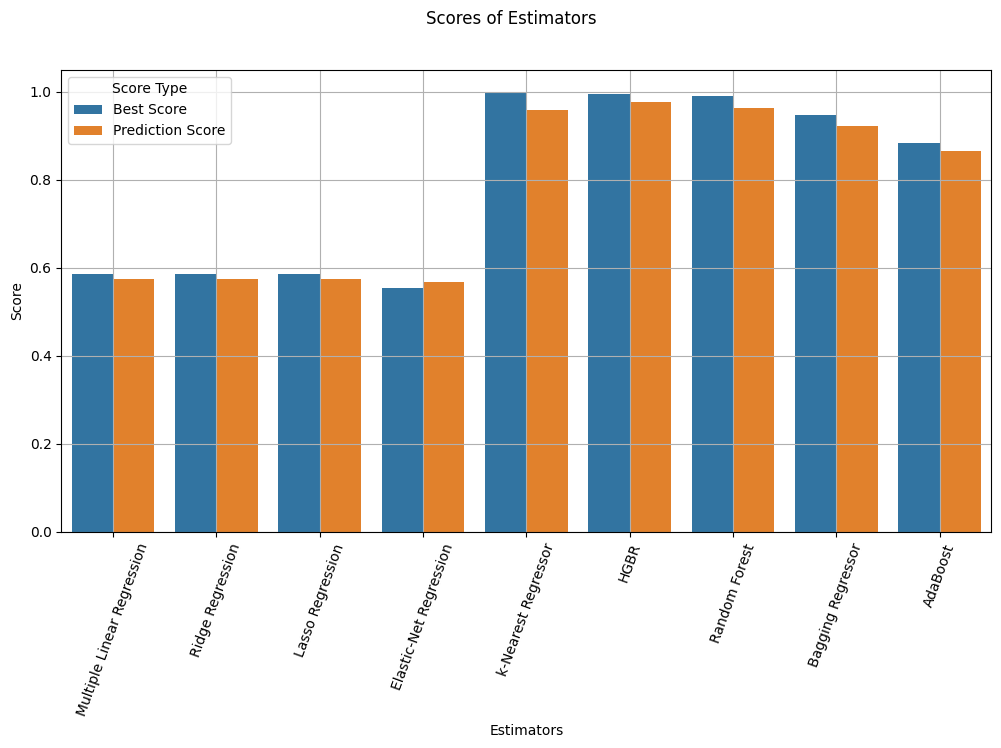

In [ ]:
fig, axs = plt.subplots(figsize=(12,6))
sns.barplot(data=estimator_df, x='Estimators', y='Score', hue='Score Type')
plt.xticks(rotation=70)
plt.suptitle('Scores of Estimators')
plt.grid()
plt.show()
save_picture(fig, 'Estimator Scores.jpeg')